In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import glob
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
from PIL import Image
import time
import sklearn.metrics
import random
from torchvision.transforms import v2
from torchvision.datasets import CIFAR10
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split

In [2]:
# set run parameters

batch_size = 32

In [3]:
# set device 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("device type:", device)
print("current device:", torch.cuda.get_device_name(torch.cuda.current_device()))

torch.multiprocessing.set_sharing_strategy('file_system')

device type: cuda
current device: NVIDIA GeForce GTX 1060 6GB


In [30]:
# create an early stopper

class EarlyStopper:
    def __init__(self, patience=1, min_change=0, mode='min'):
        self.patience = patience
        self.min_change = min_change
        self.mode = mode
        self.counter = 0
        self.min_variable = float('inf')
        self.max_variable = float('-inf')

    def stop_early(self, variable):
        if self.mode == 'min':
            if variable < self.min_variable:
                self.min_variable = variable
                self.counter = 0
            elif (variable - self.min_variable) > self.min_change:
                self.counter += 1
                if self.counter > self.patience:
                    return True

        elif self.mode == 'max':
            if variable > self.max_variable:
                self.max_variable = variable
                self.counter = 0
            elif self.max_variable > (self.min_change + variable):
                self.counter += 1
                if self.counter > self.patience:
                    return True

        return False

In [5]:
# create a dataset class

class Cifar10Dataset(Dataset):
    def __init__(self, data, targets, transform):
        self.transform = transform
        self.data = data 
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index: int):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        return img, target

In [6]:
# create datasets

preprocess = v2.Compose([
  v2.ToImage(),
  v2.ToDtype(torch.float32, scale=True),
  v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# split train data into train and validation sets without changing class distribution
cifar10 = CIFAR10(root='./../data', train=True, download=True, transform=preprocess)
data_train, data_valid, targets_train, targets_valid = train_test_split(cifar10.data, cifar10.targets, test_size=0.2, stratify=cifar10.targets)

# for consistency's sake
cifar10_test = CIFAR10(root='./../data', train=False, download=True, transform=preprocess)


# 66.66%
trainDataset = Cifar10Dataset(data_train, targets_train, transform=cifar10.transform)
trainLoader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=False)

# 16.66%
validDataset = Cifar10Dataset(data_valid, targets_valid, transform=cifar10.transform)
validLoader = DataLoader(validDataset, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=False)

# 16.66%
testDataset = Cifar10Dataset(cifar10_test.data, cifar10_test.targets, transform=cifar10_test.transform)
testLoader = DataLoader(testDataset, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=False)


labelDescription = cifar10.classes

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# create a class that will inverse the normalization of an image

class Denormalizer(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

denormalizer = Denormalizer(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

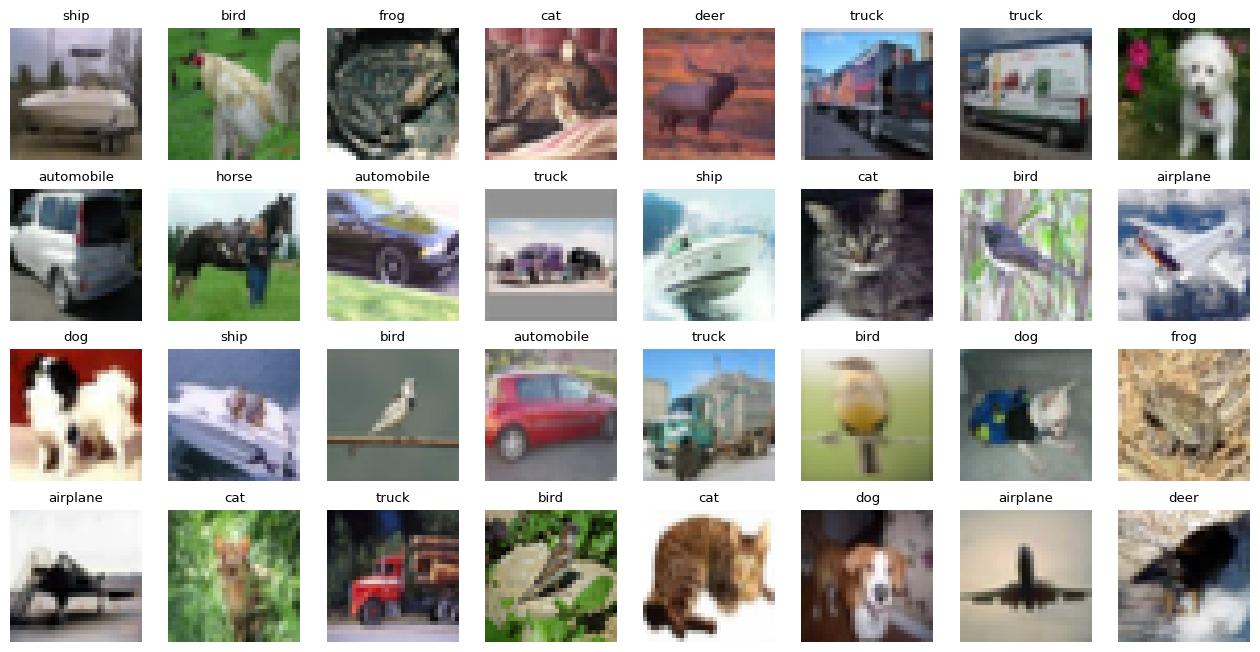

In [8]:
# show single batch of data

images_batch, labels_batch = next(iter(trainLoader))

plt.figure(figsize=(16,8))
plt.rc('font', size=8)

for i in range(len(labels_batch)):
    plt.subplot(4,8,i+1)
    plt.imshow(denormalizer(images_batch[i]).permute(1,2,0))
    plt.title(labelDescription[labels_batch[i]])
    plt.axis('off')


plt.ioff()
plt.show()

In [16]:
# define the model // TODO: those are just placeholder layers

class Cifar10Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(576, 288)
        self.fc2 = nn.Linear(288, 72)
        self.fc3 = nn.Linear(72, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x


In [31]:
# train // TODO: this is NOT tuned. no choices for hiperparameters or methods were made whatsoever either. it's just an example of how this block can be written

model = Cifar10Net().to(device)

criterion = nn.CrossEntropyLoss()
lr = 6e-3
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9) # , weight_decay=1e-5
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=0, threshold_mode='abs') 
early_stopper = EarlyStopper(patience=2, min_change=0, mode='min')
batch_print_step = 500
epochs = 50

best_train_loss = float('inf')
best_val_loss = float('inf')

train_loss_history = []
val_loss_history = []
train_f1_history = []
val_f1_history = []

for epoch in range(epochs):
    # index 0 is for training, index 1 for validation
    epoch_loss = [0, 0]
    accuracy = [0, 0]
    f1_score = [0, 0]
    epochtime = time.time()
    
    for dataset, dataloader, isTraining in [(trainDataset, trainLoader, True), (validDataset, validLoader, False)]:
        correct = 0
        running_loss = 0.0
        all_input_labels = []
        all_predicted_labels = []

        if isTraining:
            model.train()
        else:
            model.eval()

        for i, data in enumerate(dataloader, 0):        
            # get the inputs
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            if isTraining:
                # zero the parameter gradients
                optimizer.zero_grad()

            # forward 
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            loss = criterion(outputs, labels)

            if isTraining:
                # backward + optimize
                loss.backward()
                optimizer.step()

            # print statistics
            running_loss += loss.item() * images.size(0)
            correct += torch.sum(predicted == labels.data)
            all_predicted_labels.append(predicted.cpu())
            all_input_labels.append(labels.cpu())
            
            if i % batch_print_step == batch_print_step-1:
                print("\r", f'{"TRAINING" if isTraining else "VALIDATION"} PROGRESS [epoch: {epoch + 1}, {100*batch_size*(i + 1)/len(dataset):.3f}%, {math.floor(time.time() - epochtime):3d}s] loss: {running_loss / len(dataset):.3f}', end="")
                timestart = time.time()
        
        index = 0 if isTraining else 1
        epoch_loss[index] = running_loss / len(dataset)
        accuracy[index] = correct.double() / len(dataset)
        all_input_labels = np.concatenate(all_input_labels)
        all_predicted_labels = np.concatenate(all_predicted_labels)
        f1_score[index] = sklearn.metrics.f1_score(all_input_labels, all_predicted_labels, average='macro')

    print("\r" + f'EPOCH: [{epoch + 1:2d}/{epochs}, time: {math.floor(time.time() - epochtime)}s]   TRAIN: [loss: {epoch_loss[0]:.3f}, acc: {accuracy[0]:.3f}, f1: {f1_score[0]:.3f}]   VAL: [loss: {epoch_loss[1]:.3f}, acc: {accuracy[1]:.3f}, f1: {f1_score[1]:.3f}]   learning_rate: {lr}') 
    train_loss_history.append(epoch_loss[0])
    val_loss_history.append(epoch_loss[1])
    train_f1_history.append(f1_score[0])
    val_f1_history.append(f1_score[1])

    if early_stopper.stop_early(epoch_loss[1]): 
        print("stopping early")
        break

    scheduler.step(epoch_loss[1])
    lr = scheduler.get_last_lr()

print('done')

EPOCH: [ 1/50, time: 12s]   TRAIN: [loss: 1.787, acc: 0.342, f1: 0.331]   VAL: [loss: 1.481, acc: 0.475, f1: 0.458]   learning_rate: 0.006
EPOCH: [ 2/50, time: 13s]   TRAIN: [loss: 1.449, acc: 0.475, f1: 0.470]   VAL: [loss: 1.330, acc: 0.528, f1: 0.518]   learning_rate: [0.006]
EPOCH: [ 3/50, time: 11s]   TRAIN: [loss: 1.329, acc: 0.529, f1: 0.526]   VAL: [loss: 1.218, acc: 0.574, f1: 0.572]   learning_rate: [0.006]
EPOCH: [ 4/50, time: 12s]   TRAIN: [loss: 1.238, acc: 0.564, f1: 0.562]   VAL: [loss: 1.171, acc: 0.585, f1: 0.579]   learning_rate: [0.006]
EPOCH: [ 5/50, time: 12s]   TRAIN: [loss: 1.179, acc: 0.585, f1: 0.583]   VAL: [loss: 1.159, acc: 0.597, f1: 0.592]   learning_rate: [0.006]
EPOCH: [ 6/50, time: 13s]   TRAIN: [loss: 1.127, acc: 0.605, f1: 0.603]   VAL: [loss: 1.098, acc: 0.623, f1: 0.616]   learning_rate: [0.006]
EPOCH: [ 7/50, time: 14s]   TRAIN: [loss: 1.079, acc: 0.623, f1: 0.621]   VAL: [loss: 1.086, acc: 0.623, f1: 0.627]   learning_rate: [0.006]
EPOCH: [ 8/50, 

In [32]:
# test // TODO: placeholder

model.eval()

test_running_loss = 0
correct = 0
all_predicted_labels = []
all_input_labels = []

for i, data in enumerate(testLoader, 0):
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    test_running_loss += loss.item() * images.size(0)
    correct += torch.sum(predicted == labels.data)
    all_predicted_labels.append(predicted.cpu())
    all_input_labels.append(labels.cpu())

final_loss = test_running_loss / len(testDataset)
accuracy = correct.double() / len(testDataset)
all_input_labels = np.concatenate(all_input_labels)
all_predicted_labels = np.concatenate(all_predicted_labels)
f1_score = sklearn.metrics.f1_score(all_input_labels, all_predicted_labels, average='macro')

print(f'[TEST] loss: {final_loss:.3f}, accuracy: {accuracy:.3f}, f1_score: {f1_score:.3f}')

# show confusion matrix
print(', '.join([labelDescription[i] for i in range(10)]))
print(confusion_matrix(all_input_labels, all_predicted_labels, labels=[i for i in range(10)]))

[TEST] loss: 0.928, accuracy: 0.685, f1_score: 0.684
airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
[[704  23  44  24  25   7   7  15 114  37]
 [ 17 818   1  15   6   2  15   4  36  86]
 [ 57   7 540  66 123  70  70  30  25  12]
 [ 21   9  67 460  82 177  91  39  25  29]
 [ 16   5  51  81 654  36  64  68  16   9]
 [ 13   1  50 199  53 572  39  59   6   8]
 [  5   5  41  61  52  24 790   6   7   9]
 [ 14   5  34  51  77  69  12 720   4  14]
 [ 71  36  14  19   7   5  10   2 811  25]
 [ 23  89   9  25  11   1  11  13  39 779]]


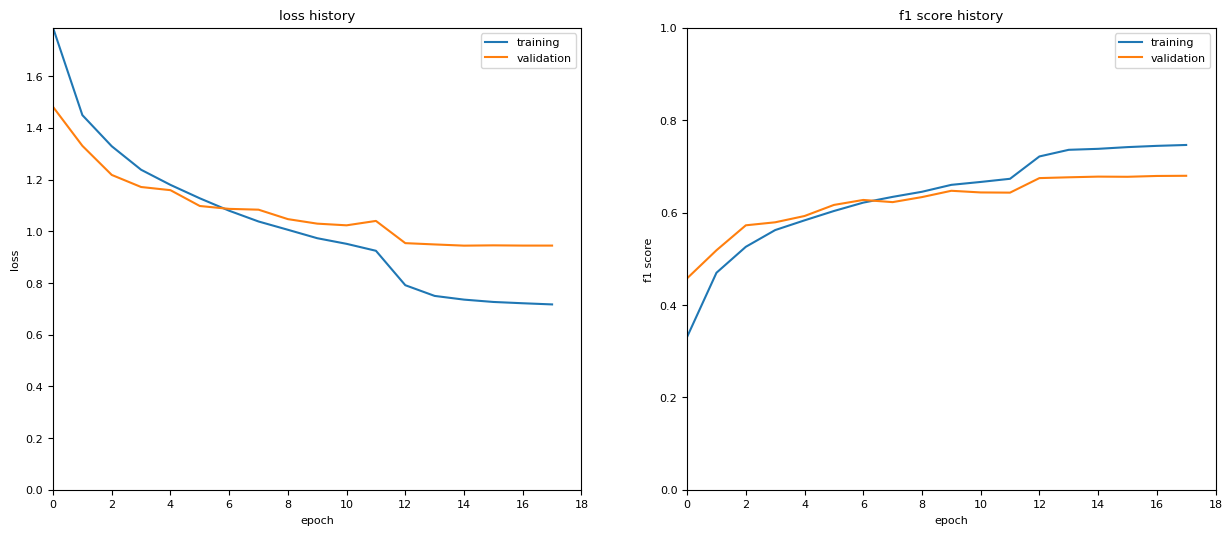

In [33]:
# plot train and validation loss

plt.figure(figsize = (15, 6))

plt.subplot(1, 2, 1)
plt.title('loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.xlim(0, len(train_loss_history))
plt.ylim(0, max(max(train_loss_history), max(val_loss_history)))
plt.plot(train_loss_history)
plt.plot(val_loss_history)
plt.legend(['training', 'validation'])

plt.subplot(1, 2, 2)
plt.title('f1 score history')
plt.xlabel('epoch')
plt.ylabel('f1 score')
plt.xlim(0, len(train_f1_history))
plt.ylim(0, 1)
plt.plot(train_f1_history)
plt.plot(val_f1_history)
plt.legend(['training', 'validation'])

plt.show()